#Assignment 3


#  Data pre-processing


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Q1**



In [2]:
batch_size = 256
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

trainset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

cuda:0


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
class Net(nn.Module):
    def __init__(self):
        #TODO: initialize the neural network layers here
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=0, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0, bias=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=4608, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        #TODO: implement the forward path here
        """
        x: batch x 1 x 28 x 28
        """
        x = F.relu(self.conv1(x)) # C1 batch x 32 x 26 x 26
        x = F.relu(self.conv2(x)) # C2 batch x 32 x 24 x 24
        x = self.max_pool(x) # P3: batch x 32 x 12 x 12
        x = torch.flatten(x, start_dim=1) # P3 flattened batch x 4608
        x = F.relu(self.fc1(x)) # F4 batch x 128
        x = self.fc2(x) # F5 batch x 10
        return x

In [4]:
@torch.no_grad()
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

def train(trainloader, net, optimizer, criterion):
    train_loss = []
    train_acc = []
    for epoch in range(10):
        running_loss = 0.0
        running_acc = 0.0

        for i, (x, labels) in enumerate(trainloader, 0):
          x = x.to(device)
          labels = labels.to(device)
          #TODO: train the net with the given data, optimizer and criterion. 

          outputs = net.forward(x)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          running_acc += accuracy(outputs, labels)

          if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            # running_loss = 0.0

        average_running_loss = running_loss / len(trainloader)
        average_running_acc = 100 * running_acc / len(trainloader)
        train_loss.append(average_running_loss)
        train_acc.append(average_running_acc)
    
    return train_loss, train_acc


def test(testloader, net):
    #TODO: Test the net and return a signle test accuracy.
    net.train(False)
    loss_list = []
    acc_list = []
    with torch.no_grad():
        for i_iter, (x, y_true) in enumerate(testloader):
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = net.forward(x)

            loss = F.cross_entropy(y_pred, y_true)

            acc = accuracy(y_pred, y_true)
            loss_list.append(loss.item())
            acc_list.append(acc)

    test_acc = np.sum(acc_list) / len(acc_list) * 100

    print(f'Accuracy of the network on the test set: {test_acc:.1f} %')
    return test_acc

In [5]:
from torchsummary import summary

In [6]:
#TODO: Train the net with Adam optimizer. 
net = Net()
net.to(device)

print(summary(net, (1,28,28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 32, 24, 24]           9,248
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Linear-4                  [-1, 128]         589,952
            Linear-5                   [-1, 10]           1,290
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.34
Params size (MB): 2.29
Estimated Total Size (MB): 2.64
----------------------------------------------------------------
None


In [7]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train(trainloader, net, optimizer, criterion)

[1,   200] loss: 0.361
[2,   200] loss: 0.072
[3,   200] loss: 0.043
[4,   200] loss: 0.032
[5,   200] loss: 0.022
[6,   200] loss: 0.017
[7,   200] loss: 0.016
[8,   200] loss: 0.010
[9,   200] loss: 0.009
[10,   200] loss: 0.008


([0.32391098712352995,
  0.07011116602002306,
  0.04273267568267406,
  0.03205387650374719,
  0.023259913826242408,
  0.017635026485956412,
  0.016089770354657494,
  0.01024162737538721,
  0.009216060761382129,
  0.008566278345174493],
 [90.57402482269505,
  97.9443705673759,
  98.72506648936171,
  99.03257978723404,
  99.2996453900709,
  99.46199024822695,
  99.47639627659575,
  99.71243351063829,
  99.69968971631207,
  99.69913563829788])

In [8]:
test(testloader, net)

Accuracy of the network on the test set: 98.8 %


98.76953125

# **Q3**


In [9]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.datasets as datasets
from sklearn.cluster import KMeans, AgglomerativeClustering

import time

In [17]:
image = np.zeros((427, 640, 3))

In [18]:
image[0][0].shape

(3,)

Width=427, Height=640, Depth=3


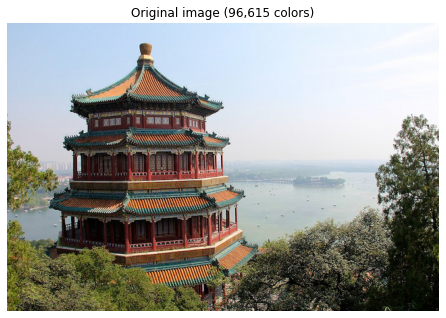

In [22]:
china_photo = datasets.load_sample_image("china.jpg")
china_photo = np.array(china_photo, dtype=np.float64) / 255
china_w, china_h, china_d = tuple(china_photo.shape)
print("Width=%s, Height=%s, Depth=%s" % (china_w, china_h, china_d))
china_image_array = np.reshape(china_photo, (china_w * china_h, china_d))
# print("In 2-D the shape is ", china_image_array.shape)

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the codebook and labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
          #TODO: reconstruct the image
          image[i][j] = codebook[labels[label_idx]]
          label_idx += 1
    return image

plt.figure()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china_photo)

Handling k = 16
Handling k = 32
Handling k = 64
Handling k = 128


<Figure size 432x288 with 0 Axes>

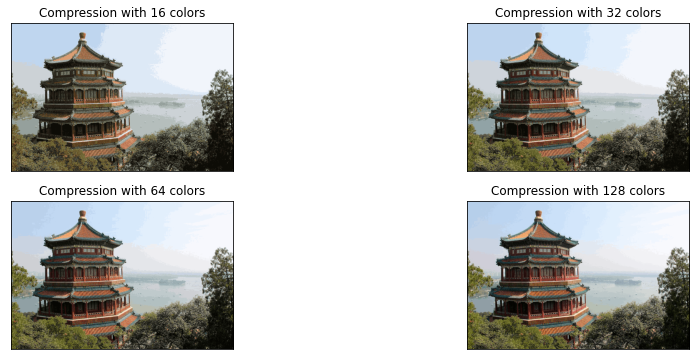

In [24]:
plt.figure()
fig,axes = plt.subplots(2, 2, figsize=(15,6))

#the 2d is for convenience
t1h_k_values = [[16, 32], [64,128]]
for i in range(2):
    for j in range(2):
        print("Handling k =", t1h_k_values[i][j])

        #TODO: call Kmeans with k=t1h_k_values[i][j] and random_state = 1234
        t1h_kmeans_obj = KMeans(n_clusters=t1h_k_values[i][j], random_state=1234)
        #TODO: fit the object with china image array variable
        t1h_kmeans_fit = t1h_kmeans_obj.fit(china_image_array)

        axes[i][j].imshow(recreate_image(t1h_kmeans_fit.cluster_centers_, t1h_kmeans_fit.labels_, china_w, china_h))
        axes[i][j].set_title('Compression with ' + str(t1h_k_values[i][j]) + " colors")
        
        axes[i][j].grid(False)
        axes[i][j].get_xaxis().set_ticks([])
        axes[i][j].get_yaxis().set_ticks([])